1. Number of Distinct Orders Each Month (Time-Series Model)

In [38]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [30]:
# Load the dataset
file_path = "C:/MBAN- Schulich/MBAN- Sem 2/Predictive Modeling/Hackathon main/fake_xyz_apparel_data.csv"  # Update with the correct path
data = pd.read_csv(file_path)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order Date               2421 non-null   object 
 1   Requested Delivery Date  2421 non-null   object 
 2   Customer Country Code    2421 non-null   object 
 3   Product Code             2421 non-null   object 
 4   Description              2421 non-null   object 
 5   Order Type               2421 non-null   object 
 6   Customer Order Code      2421 non-null   object 
 7   Value                    2421 non-null   float64
 8   Currency                 2421 non-null   object 
 9   Items                    2421 non-null   int64  
 10  Route                    2421 non-null   object 
 11  Season                   2421 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 227.1+ KB


In [39]:
# Convert Order Date to datetime and group by month
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Year-Month'] = data['Order Date'].dt.to_period('M')
monthly_orders = data.groupby('Year-Month')['Customer Order Code'].nunique()

In [40]:
# Prepare data for ARIMA
monthly_orders.index = monthly_orders.index.to_timestamp()

In [41]:
# SARIMA Model - Adding seasonality (Seasonal order as (P, D, Q, s))
# Example seasonal order (1, 1, 1, 12) - adjust based on your data
sarima_model = SARIMAX(monthly_orders, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# Forecast next 12 months
forecast = sarima_fit.get_forecast(steps=12)
forecast_summary = forecast.summary_frame()

In [44]:
print(forecast_summary)

Customer Order Code       mean    mean_se  mean_ci_lower  mean_ci_upper
2012-01-01           68.050900  10.214041      48.031747      88.070053
2012-02-01           63.995431  10.322869      43.762979      84.227884
2012-03-01           73.111986  10.329686      52.866172      93.357799
2012-04-01           61.396380  10.330393      41.149181      81.643579
2012-05-01           77.446220  10.330474      57.198862      97.693577
2012-06-01           57.944340  10.330484      37.696963      78.191717
2012-07-01           62.204838  10.330486      41.957457      82.452220
2012-08-01           71.000723  10.330489      50.753336      91.248110
2012-09-01           75.632300  10.330504      55.384884      95.879717
2012-10-01           62.597000  10.330629      42.349340      82.844661
2012-11-01           63.553353  10.331690      43.303613      83.803094
2012-12-01           74.201568  10.339433      53.936652      94.466484


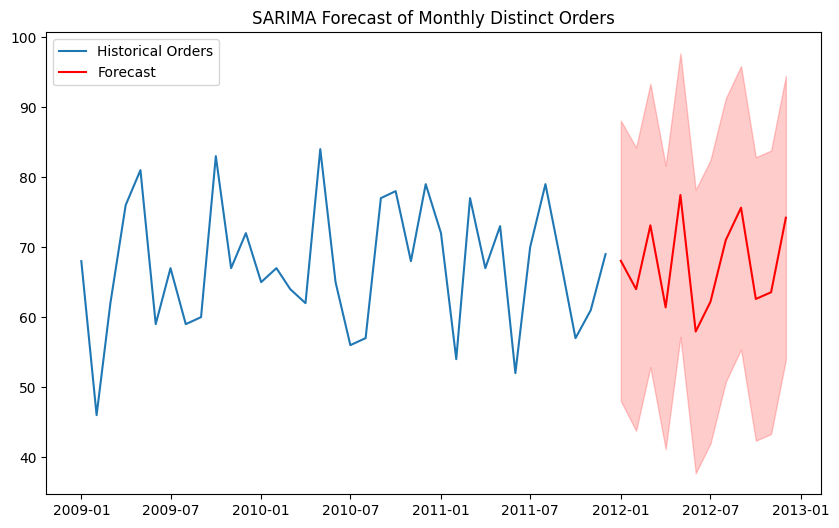

In [43]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders, label='Historical Orders')
plt.plot(forecast_summary['mean'], label='Forecast', color='red')
plt.fill_between(
    forecast_summary.index, 
    forecast_summary['mean_ci_lower'], 
    forecast_summary['mean_ci_upper'], 
    color='red', alpha=0.2
)
plt.legend()
plt.title("SARIMA Forecast of Monthly Distinct Orders")
plt.show()

In [46]:
# Example of trying different seasonal orders for model selection
from statsmodels.tsa.statespace.sarimax import SARIMAX

# List of possible seasonal orders
seasonal_orders = [(1, 1, 1, 12), (1, 0, 1, 12), (1, 1, 0, 12), (2, 1, 2, 12)]

# Fit models and compare AIC
results = []
for order in seasonal_orders:
    model = SARIMAX(monthly_orders, order=(1, 1, 1), seasonal_order=order)
    fit = model.fit(disp=False)
    results.append((order, fit.aic))

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to esti

In [47]:
# Print the AIC for each model
for result in results:
    print(f"Seasonal Order: {result[0]}, AIC: {result[1]}")

Seasonal Order: (1, 1, 1, 12), AIC: 189.46714630387683
Seasonal Order: (1, 0, 1, 12), AIC: 267.022621787413
Seasonal Order: (1, 1, 0, 12), AIC: 187.47033025876215
Seasonal Order: (2, 1, 2, 12), AIC: 193.45661770965418


2. Which Items Are Demanded (Classification Model)

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

In [69]:
# Step 1: Add a season feature based on Order Date
data['Season'] = data['Order Date'].dt.month.map(lambda x: 'Winter' if x in [12, 1, 2] else
                                                 'Spring' if x in [3, 4, 5] else
                                                 'Summer' if x in [6, 7, 8] else 'Autumn')

In [70]:
# Step 2: One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_season = encoder.fit_transform(data[['Season']])
season_encoded_df = pd.DataFrame(encoded_season, columns=encoder.get_feature_names_out(['Season']))

In [71]:
# Step 3: Encode 'Product Code' using LabelEncoder
label_encoder = LabelEncoder()
data['Product Code_encoded'] = label_encoder.fit_transform(data['Product Code'])

# Combine the encoded data with the original dataframe
data = pd.concat([data, season_encoded_df], axis=1)

In [72]:
# Step 4: Handle class imbalance using SMOTE
categorical_features = ['Customer Country Code', 'Route']
numerical_features = ['Value', 'Items'] + list(season_encoded_df.columns) + ['Product Code_encoded']  # Including encoded seasons and Product Code

X = data[categorical_features + numerical_features]
y = data['Product Code']

In [73]:
# Step 5: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# Step 6: Preprocessing - One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

In [75]:
# Step 7: Handling class imbalance - Use SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [76]:
# Step 8: Define the RandomForestClassifier with class_weight='balanced' to handle imbalance
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

In [77]:
# Step 9: Create a pipeline for preprocessing and model training
pipeline = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', classifier)
])

In [78]:
# Step 10: Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters from grid search
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [79]:
# Step 11: Evaluate the model
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       P0001       0.58      1.00      0.74         7
       P0002       0.85      0.69      0.76        16
       P0003       0.67      0.55      0.60        11
       P0004       0.54      0.78      0.64         9
       P0005       0.45      0.38      0.42        13
       P0006       0.22      0.18      0.20        11
       P0007       0.33      0.22      0.27        18
       P0008       0.33      0.31      0.32        13
       P0009       0.08      0.14      0.11         7
       P0010       0.27      0.38      0.32         8
       P0011       0.25      0.33      0.29         6
       P0012       0.43      0.38      0.40         8
       P0013       0.33      0.33      0.33         6
       P0014       0.40      0.25      0.31        16
       P0015       0.43      0.33      0.38         9
       P0016       0.27      0.43      0.33         7
       P0017       0.33      0.56      0.42         9
       P0018       0.25    

3. Quantity Demanded for Each Item (Regression Model or Empirical Quantiles)

In [22]:
from scipy.stats.mstats import mquantiles
import numpy as np

In [23]:
# Calculate empirical quantiles for each product
product_quantiles = data.groupby('Product Code')['Items'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
).reset_index(name='Quantiles')

print(product_quantiles)

   Product Code                                      Quantiles
0         P0001  [25.799999999999997, 47.5, 77.55000000000001]
1         P0002  [29.349999999999998, 50.0, 71.64999999999999]
2         P0003                           [11.45, 52.5, 81.55]
3         P0004  [18.799999999999997, 44.0, 74.80000000000001]
4         P0005              [25.649999999999995, 51.5, 70.05]
5         P0006               [30.499999999999996, 51.0, 80.3]
6         P0007                [20.0, 45.5, 80.64999999999999]
7         P0008                             [23.4, 55.0, 79.6]
8         P0009                [29.49999999999999, 55.0, 74.3]
9         P0010                            [23.95, 38.5, 73.0]
10        P0011                [31.0, 55.0, 81.19999999999999]
11        P0012               [35.64999999999999, 55.0, 75.05]
12        P0013  [35.699999999999996, 53.0, 70.64999999999999]
13        P0014                             [38.4, 62.0, 83.8]
14        P0015                             [36.4, 62.0

4. Demand Lead Time (Empirical Analysis)

In [24]:
# Calculate lead time
data['Lead Time'] = (pd.to_datetime(data['Requested Delivery Date']) - data['Order Date']).dt.days

In [25]:
# Empirical quantiles of lead time
lead_time_quantiles = mquantiles(data['Lead Time'], prob=[0.25, 0.5, 0.75])
print("Lead Time Quantiles (25%, 50%, 75%):", lead_time_quantiles)

Lead Time Quantiles (25%, 50%, 75%): [ 67. 104. 142.]


5. Monte Carlo Simulation for Consolidated Forecast

In [32]:
# Extract unique product codes from the dataset
product_codes = data['Product Code'].unique()

In [82]:
# Simulation parameters
n_simulations = 1000

# Initialize the lists to store the results for both lead times
simulated_total_demand_5_month = []  # For the 5-month lead time
simulated_total_demand_2_month = []  # For the 2-month lead time

In [83]:
# Use monthly_orders if it has been calculated already
if 'monthly_orders' not in locals():
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Year-Month'] = data['Order Date'].dt.to_period('M')
    monthly_orders = data.groupby('Year-Month')['Customer Order Code'].nunique()

In [84]:
# Run simulations
for _ in range(n_simulations):
    # Simulate number of orders in a month using Poisson distribution
    simulated_monthly_orders = np.random.poisson(monthly_orders.mean())
    
    # Randomly select a product code
    simulated_item_choice = np.random.choice(product_codes)
    
    # Simulate item quantity
    simulated_quantity = np.random.choice(data['Items'])
    
    # Calculate and record total demand for the simulation with 5-month lead time
    simulated_total_demand_5_month.append(simulated_monthly_orders * simulated_quantity * 5)  # 5-month horizon
    
    # Calculate and record total demand for the simulation with 2-month lead time
    simulated_total_demand_2_month.append(simulated_monthly_orders * simulated_quantity * 2)  # 2-month horizon

In [85]:
# Convert simulated results to numpy arrays for analysis
simulated_total_demand_5_month = np.array(simulated_total_demand_5_month)
simulated_total_demand_2_month = np.array(simulated_total_demand_2_month)

In [87]:
# Analyze simulated results for 5-month lead time
mean_5_month = simulated_total_demand_5_month.mean()
ci_5_month = np.percentile(simulated_total_demand_5_month, [2.5, 97.5])

# Analyze simulated results for 2-month lead time
mean_2_month = simulated_total_demand_2_month.mean()
ci_2_month = np.percentile(simulated_total_demand_2_month, [2.5, 97.5])

In [88]:
# Print results
print("5-Month Lead Time - Simulated Demand Mean:", mean_5_month)
print("5-Month Lead Time - Simulated Demand 95% CI:", ci_5_month)

print("\n2-Month Lead Time - Simulated Demand Mean:", mean_2_month)
print("2-Month Lead Time - Simulated Demand 95% CI:", ci_2_month)

5-Month Lead Time - Simulated Demand Mean: 17018.97
5-Month Lead Time - Simulated Demand 95% CI: [ 1199.    35000.875]

2-Month Lead Time - Simulated Demand Mean: 6807.588
2-Month Lead Time - Simulated Demand 95% CI: [  479.6  14000.35]


Compare MAPE for Both Lead Times

In [94]:
# Check column names in X_test
print(X_test.columns)

Index(['Customer Country Code', 'Route', 'Value', 'Items', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Product Code_encoded'],
      dtype='object')


In [96]:
# Aggregate actual demand by 'Product Code_encoded'
# Assuming 'Product Code_encoded' is now the correct column name
actual_demand_agg = X_test.groupby('Product Code_encoded')['Items'].sum()

# Ensure simulated total demand is aggregated by 'Product Code_encoded'
# Aggregating simulated demand by product code encoded
simulated_total_demand_5_month_agg = {product_code: np.mean([simulated_total_demand_5_month[i] for i in range(n_simulations) if simulated_item_choice == product_code]) for product_code in product_codes}
simulated_total_demand_2_month_agg = {product_code: np.mean([simulated_total_demand_2_month[i] for i in range(n_simulations) if simulated_item_choice == product_code]) for product_code in product_codes}

# Now ensure the simulated demand is aggregated by 'Product Code_encoded' and has the same shape as actual demand
# For each product code encoded, calculate MAPE

# MAPE for 5-month lead time
mape_5_month = np.mean(np.abs((np.array(list(simulated_total_demand_5_month_agg.values())) - actual_demand_agg) / actual_demand_agg)) * 100

# MAPE for 2-month lead time
mape_2_month = np.mean(np.abs((np.array(list(simulated_total_demand_2_month_agg.values())) - actual_demand_agg) / actual_demand_agg)) * 100

# Print MAPE results
print("MAPE for 5-Month Lead Time:", mape_5_month)
print("MAPE for 2-Month Lead Time:", mape_2_month)

MAPE for 5-Month Lead Time: 2202.9729364005416
MAPE for 2-Month Lead Time: 821.1891745602164
